In [1]:
# establish_confidence.ipynd
# trying to establish the level of confidence score, 
# and rank elements based on it. (prev. ranking only depended on # of overlapping elements.
# need to include non-overlapping elements as well)
import collections
import itertools
import libsbml
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import requests

import matplotlib.pyplot as plt
%matplotlib inline  

script_path = "/Users/woosubs/Desktop/AutomateAnnotation/reaction_recommender/reaction_recommender/"
os.sys.path.append(script_path)

# import get_annotation as ga
from reaction_recommender import annotation_container as ac
from reaction_recommender import reaction_recommender as recommender

BASE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/'
BIOMD_12 = 'BIOMD0000000012.xml'
DATA_DIR = os.path.join(BASE_DIR, "DATA")
RHEA_DIR = os.path.join(DATA_DIR, "rhea")
# BioModel files
BIOMODEL_DIR = os.path.join(DATA_DIR, "biomodels/curated_biomodels_31mar2021")
biomd_files = [f for f in os.listdir(BIOMODEL_DIR) if f[-4:] == ".xml"]
print(len(biomd_files))
biomd_fpaths = [os.path.join(BIOMODEL_DIR, one_file) for one_file in biomd_files]

# BiGG files
BIGG_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/DATA/bigg'
ecoli_fpath = os.path.join(BIGG_DIR, "e_coli_core.xml")
bigg_files = [f for f in os.listdir(BIGG_DIR) if f[-4:]=='.xml']
bigg_fpaths = [os.path.join(BIGG_DIR, f) for f in bigg_files]
print(len(bigg_files))
one_fpath = bigg_fpaths[0]

1000
108


In [2]:
# Nov 14, 2021: using a shortened version, meaning H and D are removed
with open(os.path.join(DATA_DIR, 'all_shortened_chebi_to_formula_19nov2021.pkl'), 'rb') as f:
  ref_shortened_chebi_to_formula = pickle.load(f)
# below is full version
with open(os.path.join(DATA_DIR, 'all_possible_chebi_to_formula_12nov2021.pkl'), 'rb') as f:
  ref_full_chebi_to_formula = pickle.load(f)
# map secondary id to primary id
with open(os.path.join(DATA_DIR, 'chebi_second2prime_8nov2021.pickle'), 'rb') as f:
  ref_second2prime_dict = pickle.load(f)
# RHEA All Ids to Bi Id (KEGG Mappable)
with open(os.path.join(RHEA_DIR, 'rhea_all2bi.pkl'), 'rb') as f:
  ref_rhea2bi = pickle.load(f)
with open(os.path.join(RHEA_DIR, 'rhea_all2master.pkl'), 'rb') as f:
  ref_rhea2master = pickle.load(f)
with open(os.path.join(RHEA_DIR, 'rhea2chebi_reference.pkl'), 'rb') as f:
  ref_rhea2chebi = pickle.load(f)

In [59]:
anot_container = ac.AnnotationContainer(model_file=os.path.join(BIGG_DIR, ecoli_fpath))
reader = libsbml.SBMLReader()
document = reader.readSBML(ecoli_fpath)
model = document.getModel()

In [42]:
df = pd.read_csv(os.path.join(RHEA_DIR, 'rhea_string_equation.tsv'), sep='\t', index_col=0)
df.head()

,equation
id,
RHEA:10000,H2O + pentanamide = NH4(+) + pentanoate
RHEA:10004,benzyl isothiocyanate = benzyl thiocyanate
RHEA:10008,[protein]-dithiol + a hydroperoxide = [protein...
RHEA:10012,(R)-6-hydroxynicotine + H2O + O2 = 6-hydroxyps...
RHEA:10016,H2O + O-sinapoylcholine = choline + E-sinapate...


In [5]:
recom = recommender.ReactionRecommender(model_file=os.path.join(BIGG_DIR, ecoli_fpath))

In [12]:
print(list(recom.reac_dict.keys()))

['R_PFK', 'R_PFL', 'R_PGI', 'R_PGK', 'R_PGL', 'R_ACALD', 'R_AKGt2r', 'R_PGM', 'R_PIt2r', 'R_ALCD2x', 'R_ACALDt', 'R_ACKr', 'R_PPC', 'R_ACONTa', 'R_ACONTb', 'R_ATPM', 'R_PPCK', 'R_ACt2r', 'R_PPS', 'R_ADK1', 'R_AKGDH', 'R_ATPS4r', 'R_PTAr', 'R_PYK', 'R_BIOMASS_Ecoli_core_w_GAM', 'R_PYRt2', 'R_CO2t', 'R_RPE', 'R_CS', 'R_RPI', 'R_SUCCt2_2', 'R_CYTBD', 'R_D_LACt2', 'R_ENO', 'R_SUCCt3', 'R_ETOHt2r', 'R_SUCDi', 'R_SUCOAS', 'R_TALA', 'R_THD2', 'R_TKT1', 'R_TKT2', 'R_TPI', 'R_EX_ac_e', 'R_EX_acald_e', 'R_EX_akg_e', 'R_EX_co2_e', 'R_EX_etoh_e', 'R_EX_for_e', 'R_EX_fru_e', 'R_EX_fum_e', 'R_EX_glc__D_e', 'R_EX_gln__L_e', 'R_EX_glu__L_e', 'R_EX_h_e', 'R_EX_h2o_e', 'R_EX_lac__D_e', 'R_EX_mal__L_e', 'R_EX_nh4_e', 'R_EX_o2_e', 'R_EX_pi_e', 'R_EX_pyr_e', 'R_EX_succ_e', 'R_FBA', 'R_FBP', 'R_FORt2', 'R_FORt', 'R_FRD7', 'R_FRUpts2', 'R_FUM', 'R_FUMt2_2', 'R_G6PDH2r', 'R_GAPD', 'R_GLCpts', 'R_GLNS', 'R_GLNabc', 'R_GLUDy', 'R_GLUN', 'R_GLUSy', 'R_GLUt2r', 'R_GND', 'R_H2Ot', 'R_ICDHyr', 'R_ICL', 'R_LDH_D', '

In [29]:
# rid = ['R_PFK', 'R_PFL']
# candidates = recom.getCandidatesByReactionId(reaction_ids=rid)
candidates = recom.getCandidatesByReactionId()

In [14]:
recom.sortCandidates(['RHEA:12423', 'RHEA:13380', 'RHEA:14216', 'RHEA:15656', 'RHEA:16112'])

['RHEA:12423', 'RHEA:13380', 'RHEA:14216', 'RHEA:15656', 'RHEA:16112']

In [30]:
recom.maxes

R_PFK        5
R_PFL        4
R_PGI        1
R_PGK        4
R_PGL        4
            ..
R_NADH16     3
R_NADTRHD    2
R_NH4t       1
R_O2t        1
R_PDH        5
Length: 95, dtype: int64

In [32]:
recom.multi_mat.iloc[:5, :5]

,R_PFK,R_PFL,R_PGI,R_PGK,R_PGL
RHEA:10003,0,0,0,0,1
RHEA:10007,0,0,0,0,0
RHEA:10011,0,0,0,0,1
RHEA:10015,0,0,0,0,1
RHEA:10019,1,0,0,0,2


In [33]:
recom.query_mat.iloc[:5, :5]

,R_PFK,R_PFL,R_PGI,R_PGK,R_PGL
C2N3,0,0,0,0,0
C21O11,0,0,0,0,0
C22O3,0,0,0,0,0
C13N3O2,0,0,0,0,0
C4N4O,0,0,0,0,0


In [41]:
# number of existing elements in a given species set
query_array = np.count_nonzero(recom.query_mat, axis=0)
query_array

array([ 5,  4,  1,  4,  4,  5,  2,  1,  2,  3,  1,  4,  6,  3,  3,  5,  5,
        2,  7,  3,  5,  5,  4,  5, 19,  2,  1,  1,  6,  1,  2,  4,  2,  3,
        2,  2,  2,  6,  4,  3,  3,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  4,  2,  1,  2,
        4,  3,  2,  3,  5,  4,  7,  6,  6,  4,  5,  2,  4,  1,  4,  3,  3,
        6,  2,  3,  4,  4,  3,  2,  1,  1,  5])

In [52]:
# number of maximum matches
match_array = np.array(recom.maxes)
match_array

array([5, 4, 1, 4, 4, 5, 2, 1, 2, 3, 1, 4, 6, 3, 3, 5, 5, 2, 7, 3, 5, 5,
       4, 5, 7, 2, 1, 1, 6, 1, 2, 3, 2, 3, 2, 2, 2, 6, 4, 3, 3, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 2,
       1, 2, 4, 3, 2, 3, 5, 4, 7, 6, 6, 4, 5, 2, 4, 1, 4, 3, 3, 6, 2, 3,
       4, 4, 3, 2, 1, 1, 5])

In [54]:
given_array - match_array

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [55]:
# get confidence
# (num matches / num non_matches) * num_total_components (but normalized)

### To normalize the number of total_components, first calculate from which total matching components the prediction gets almost 100% accurate.

In [4]:
def getTrueReactionAnnotation(container, reaction_id, qualifier_type='rhea'):
  """
  Get the list of true reaction annotations, 
  so that we can check whether 
  the predicted id was correct. 
  returrn: list-str/None
  """
  one_anot = container.model.getReaction(reaction_id).getAnnotationString()
  rhea_nums = container.getQualifierFromString(input_str=one_anot, qualifier=qualifier_type)
  if rhea_nums:
    return['RHEA:'+val for val in rhea_nums]
  else:
    return None

In [95]:
CANDIDATE_NUM = 5
# recom = recommender.ReactionRecommender(model_file=os.path.join(BIGG_DIR, ecoli_fpath))
recom = recommender.ReactionRecommender(model_file=bigg_fpaths[0])
anot_container = ac.AnnotationContainer(model_file=bigg_fpaths[0])
candidates = recom.getCandidatesByReactionId()
match_list = list(recom.maxes)
#
all_reaction_ids = list(recom.reac_dict.keys())
result = []
max_matches = []
recorded_reactions = []
for idx, one_reaction_id in enumerate(all_reaction_ids):
  true_vaules = getTrueReactionAnnotation(container=anot_container,
                                          reaction_id=one_reaction_id,
                                          qualifier_type='rhea')
  if true_vaules is None:
    # no need to collect None
    continue
#     result.append(None)
  else:
    # candidates = recom.getCandidatesByReactionId(reaction_ids=one_reaction_id)
    recorded_reactions.append(one_reaction_id)
    ranked_candidates = recom.sortCandidates(candidate_list=candidates[one_reaction_id])[:CANDIDATE_NUM]
    intersects = [val in ranked_candidates for val in true_vaules]
    # determine if result is correct
    result.append(any(intersects))
    max_matches.append(match_list[idx])

In [96]:
true_matches5 = [max_matches[idx] for idx in range(len(result)) if result[idx]==True]
false_matches5 = [max_matches[idx] for idx in range(len(result)) if result[idx]==False]

In [101]:
len(recorded_reactions)

1212

In [102]:
len(false_matches5) + len(true_matches5)

1212

In [104]:
len(false_matches5)

50

In [ ]:
# establish some kind of data frame to establish P(X=True). i.e., confidence

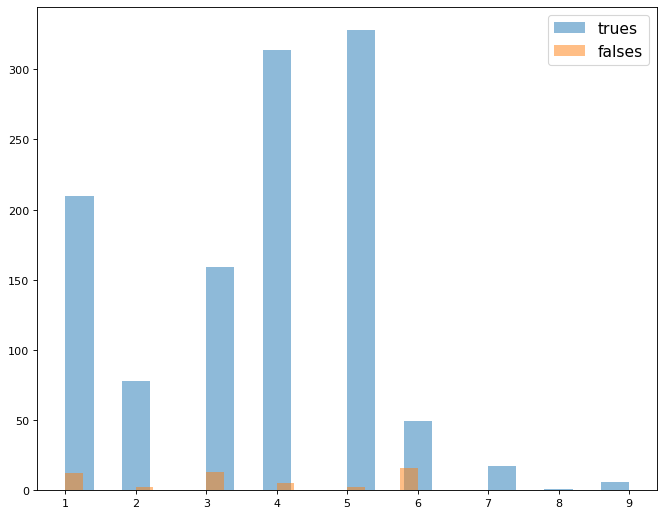

In [17]:
plt.figure(figsize=(10, 8), dpi=80)
data1 = true_matches5
data2 = false_matches5
plt.hist(data1, bins=20, alpha=0.5, label="trues")
plt.hist(data2, bins=20, alpha=0.5, label="falses")
# plt.xlabel("Precision", size=14)
# plt.ylabel("Frequency", size=14)
plt.legend(loc='best', prop={'size': 14})

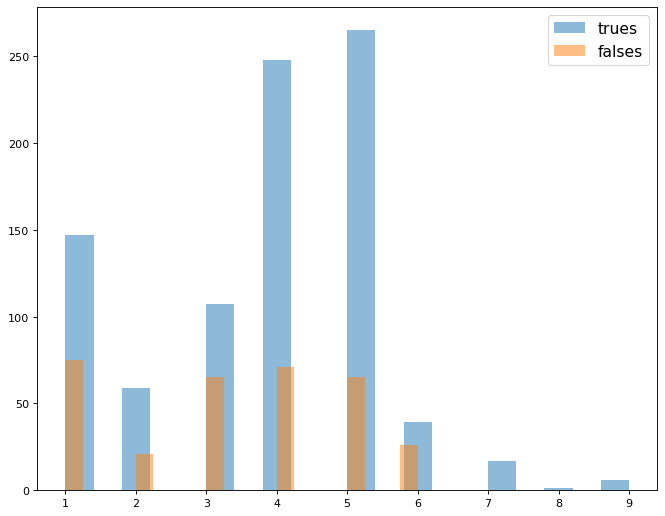

In [14]:
plt.figure(figsize=(10, 8), dpi=80)
data1 = true_matches1
data2 = false_matches1
plt.hist(data1, bins=20, alpha=0.5, label="trues")
plt.hist(data2, bins=20, alpha=0.5, label="falses")
# plt.xlabel("Precision", size=14)
# plt.ylabel("Frequency", size=14)
plt.legend(loc='best', prop={'size': 14})

In [27]:
reader = libsbml.SBMLReader()
document = reader.readSBML(bigg_fpaths[0])
model = document.getModel()

In [28]:
num_reacts = []
num_prods = []
for one_rid in recorded_reactions:
  reaction = model.getReaction(one_rid)
  num_reacts.append(reaction.getNumReactants())
  num_prods.append(reaction.getNumProducts())

In [105]:
# pred_df = pd.DataFrame(zip(result, max_matches, num_reacts, num_prods),
#                   columns =["Y", "max_matches", "num_reacts", "num_prods"],
#                  index=recorded_reactions)

In [117]:
# basically, correctly predicted in the top 1?
pred_df1 = pd.read_csv("pred_df_match1.csv", index_col=0)
pred_df1.head()

,Y,max_matches,num_reacts,num_prods
R_2AMACHYD,True,4,2,2
R_2HBO,False,3,2,3
R_1PPDCRp,True,3,3,2
R_42A12BOOX,True,5,3,3
R_4ABUTtcn,True,1,1,1


In [118]:
# correctly predicted with the top 5 candidates?
pred_df5 = pd.read_csv("pred_df_match5.csv", index_col=0)
pred_df5.head()

,Y,max_matches,num_reacts,num_prods
R_2AMACHYD,True,4,2,2
R_2HBO,True,3,2,3
R_1PPDCRp,True,3,3,2
R_42A12BOOX,True,5,3,3
R_4ABUTtcn,True,1,1,1


In [112]:
# pred_df.to_csv("pred_df_match1.csv")
# pred_df.to_csv("pred_df_match5.csv")

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [122]:
pred_df = pred_df1

X = np.array(pred_df.iloc[:, 1:])
y = pred_df["Y"]
skf = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(random_state=0)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=skf)
print(scores)
print("Mean:", scores.mean())

[0.76229508 0.76229508 0.53719008 0.70247934 0.68595041 0.74380165
 0.72727273 0.74380165 0.75206612 0.7768595 ]
Mean: 0.7194011651537732


In [123]:
pred_df = pred_df5

X = np.array(pred_df.iloc[:, 1:])
y = pred_df["Y"]
skf = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(random_state=0)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=skf)
print(scores)
print("Mean:", scores.mean())

[0.98360656 0.95901639 0.97520661 0.94214876 0.96694215 0.95867769
 0.96694215 0.95041322 0.98347107 0.97520661]
Mean: 0.9661631215282483


In [75]:
pred_df.iloc[0,1:]

max_matches    4
num_reacts     2
num_prods      2
Name: R_2AMACHYD, dtype: object

In [76]:
np.sum(p1[0])

0.9999999999999999